# Build NN model to predict TPSA from Pharmacophores

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [ ]:
# Models
import os, sys
import math
import pickle
import itertools
import copy 
import joblib
import logging 
import types
# from multiprocessing import Pool, process
from datetime import datetime, time
from collections import defaultdict
from collections.abc import Iterator

from utils_cellpainting import *
from utils import display_gpu_info, display_gpu_device_info
from utils_ml import model_selection 

from multiprocessing import Pool, process

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import dask.dataframe as dd 
pp = PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 170


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor


In [8]:
import dask
import dask_ml.model_selection as dcv
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV, IncrementalSearchCV, HyperbandSearchCV
from dask.distributed import Client
from dask.distributed import LocalCluster
import joblib
# from dask_cuda import LocalCUDACluster
# from sklearn.model_selection import GridSearchCV


In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


# utility class to help normalize labels such that they contain only values between 0 and n_classes-1. 
from sklearn.preprocessing import LabelEncoder, Normalizer, normalize, MaxAbsScaler,MinMaxScaler

#K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import train_test_split, KFold

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score 

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set, 
# and its prediction is computed with an estimator fitted on the corresponding training set.

from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

#Input checker utility for building a cross-validator.(?)

from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring 
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score, 
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that 
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).

from sklearn.metrics import make_scorer

#regression matrics

from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score

#classification metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model 
# in an estimator without actually copying attached data. It returns a new estimator with the same 
# parameters that has not been fitted on any data.

from sklearn.base import clone

In [9]:
def result_model_selection(results, name):
    df_results = pd.DataFrame({'model'     : [name] * len(results.cv_results_['params']),
                               'params'    : results.cv_results_['params'],
                               'mean score': results.cv_results_['mean_test_score'],
                               'std score' : results.cv_results_['std_test_score'],
                               'rank'      : results.cv_results_['rank_test_score']
                              })
    return df_results

In [3]:
def make_cv_splits(n_folds: int = 5,) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test = splits[i]
        yield dd.concat(train), test

In [10]:
gzip_compression_options = {"method": "gzip", 'compresslevel': 1,"mtime": 1}

metadata_path = "../cj-datasets/metadata"
plates = pd.read_csv(os.path.join(metadata_path,"plate.csv.gz"))
wells = pd.read_csv(os.path.join(metadata_path,"well.csv.gz"))
compound = pd.read_csv(os.path.join(metadata_path,"compound.csv.gz"))
orf = pd.read_csv(os.path.join(metadata_path,"orf.csv.gz"))


## gz, bz2, zip, tar, tar.gz, tar.bz2
# types = ['.gz', '.bz2','.zip', '.tar', '.tar.gz', '.tar.bz2']
type_bz2 = 'bz2'
type_gzip = 'gz'


## Datasets

In [11]:
prefix = '' ### Target-2' , 'MOA'

input_path ="./input/"
output_path ="./output_11102023/"

prefix_lc = prefix.lower().replace('-', '_')
 
# compoundMetadataInputFile   = f"{input_path}JUMP-{prefix}_compound_library.csv"

compoundMetadataInputFile          = f"{output_path}{prefix_lc}_compound_metadata.csv"
compoundMetadataCleanFile          = f"{output_path}{prefix_lc}_compound_metadata_clean.csv"
compoundMetadataTPSAFile           = f"{output_path}{prefix_lc}_compound_metadata_tpsa.csv"
compoundMetadataTPSACleanFile      = f"{output_path}{prefix_lc}_compound_metadata_tpsa_clean.csv"
compoundTPSAFile                   = f"{output_path}{prefix_lc}_compound_TPSA.csv"
compoundTPSACleanFile              = f"{output_path}{prefix_lc}_compound_TPSA_clean.csv"
compoundPharmacophoreFile          = f"{output_path}{prefix_lc}_compound_pharmacophores_sparse.pkl"
compoundPharmacophoreCleanFile     = f"{output_path}{prefix_lc}_compound_pharmacophores_sparse_clean.pkl"
compoundPharmacophoreDenseZipFile  = f"{output_path}{prefix_lc}_compound_pharmacophores_dense.npz"
CompoundExtendedMetadataFile        = f"{output_path}{prefix_lc}compound_extended_metadata.csv"

CompoundExtendedMetadata5SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_5samples.csv"
CompoundProfiles5SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_5samples.csv"

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_2samples.csv"

# CompoundProfiles2SampleFileParquet  = f"{output_path}{prefix_lc}compound_profiles_2samples.parquet"
# CompoundProfiles2SampleFileGZ       = f"{output_path}{prefix_lc}compound_profiles_2samples.gz"

CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}compound_extended_metadata_samples.csv"
featureSelectionFile                = f"{output_path}{prefix_lc}_normalized_feature_select.csv.gz"

In [12]:
print(f" ")
print(f" compound Metadata Input File             : {compoundMetadataInputFile}")
print(f" compound Metadata Output File            : {compoundMetadataCleanFile}\n")
print(f" compound Metadata + TPSA File            : {compoundMetadataTPSAFile}")
print(f" compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
print(f" compound TPSA File                       : {compoundTPSAFile}")
print(f" compound TPSA Clean File                 : {compoundTPSACleanFile}")
print()
print(f" compound Pharmacophore Sparse File       : {compoundPharmacophoreFile}")
print(f" compound Pharmacophore Sparse Clean File : {compoundPharmacophoreCleanFile}")
print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")
print(f" ")
print(f" Compound Extended MetadataFile           : {CompoundExtendedMetadataFile }")
print(f" Compound Extended Metadata 5 SampleFile  : {CompoundExtendedMetadata5SampleFile }")
print(f" Compound Profiles 5 Sample File CSV      : {CompoundProfiles5SampleFileCSV }")
print()
print(f" Compound Extended Metadata 2 SampleFile  : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV     : {CompoundProfiles2SampleFileCSV}")
# print(f" ")
# print(f" CompoundProfiles2SamplesFile Parquet        : {CompoundProfiles2SampleFileParquet }")
# print(f" CompoundProfiles2SamplesFile gz             : {CompoundProfiles2SampleFileGZ }")
print(f" ")
print(f" featureSelectionFile                     : {featureSelectionFile}")

 
 compound Metadata Input File             : ./output_11102023/_compound_metadata.csv
 compound Metadata Output File            : ./output_11102023/_compound_metadata_clean.csv

 compound Metadata + TPSA File            : ./output_11102023/_compound_metadata_tpsa.csv
 compound Metadata + TPSA Cleaned File    : ./output_11102023/_compound_metadata_tpsa_clean.csv

 compound TPSA File                       : ./output_11102023/_compound_TPSA.csv
 compound TPSA Clean File                 : ./output_11102023/_compound_TPSA_clean.csv

 compound Pharmacophore Sparse File       : ./output_11102023/_compound_pharmacophores_sparse.pkl
 compound Pharmacophore Sparse Clean File : ./output_11102023/_compound_pharmacophores_sparse_clean.pkl
 compound Pharmacophore Dense Zipped File : ./output_11102023/_compound_pharmacophores_dense.npz
 
 Compound Extended MetadataFile           : ./output_11102023/compound_extended_metadata.csv
 Compound Extended Metadata 5 SampleFile  : ./output_11102023/compound_

# Data Load and Prep

### Create dask cluster and client 

In [13]:
# cluster = LocalCluster()
# cluster = LocalCluster("Kevins_Cluster", n_workers=2, threads_per_worker=2)
# client = Client("tcp://127.0.0.1:37937")
# client = Client(cluster.scheduler_address)

In [14]:
# cluster.workers
# cluster.scale(2)
# cluster.close()
# client.close()
# del cluster

In [15]:
# client
# cluster.name
# print(cluster)
# cluster.dashboard_link
# cluster.scheduler_address
# cluster.scheduler_spec
# cluster.workers

In [16]:
# cluster.scheduler.stop()
# cluster.scheduler.close()

In [17]:
# client 
# client.status
# client.connection_args
# del client

### Read parquet column metadata file

In [ ]:
# with open("./metadata/parquet_columns.pkl",'rb') as f:
#     ParquetColumns = pickle.load(f)

# for k,v in ParquetColumns.items():
#     print(f" {k:20s}   items: {len(v)}")

In [ ]:
# type(ParquetColumns['Cells']['Cells_AreaShape_Area'])
# ParquetColumns['Cells']
# del ParquetColumns


### Read column metadata file

In [18]:
with open("./metadata/feature_selection_columns.pkl", 'rb') as f: 
    x = pickle.load(f)
for i in x:
    print(f" {i:20s}    {len(x[i])} ")

X_columns = [] ## ["Metadata_JCP2022"]
y_columns = [] ## ["Metadata_JCP2022"]
X_columns.extend(x['selected'])
y_columns.extend(["Metadata_log10TPSA"])
 

x_columns_drop = ["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "Metadata_TPSA", "Metadata_lnTPSA", "Metadata_log10TPSA"]
x_columns_drop.extend(["Metadata_JCP2022"])

columns_read = ["Metadata_JCP2022", "Metadata_log10TPSA"]
print(f" len(columns_read) : {len(columns_read)}")

columns_read.extend(x['selected'])
print(f" len(columns_read) : {len(columns_read)}")

 selected                1477 
 dropped_correlation     2193 
 dropped_variance        0 
 len(columns_read) : 2
 len(columns_read) : 1479


### Read compound profiles

In [19]:
# Apply feature selection
profilesFile = CompoundProfiles2SampleFileCSV ## +'.'+ type_bz2
featureSelectionFile = './output_11102023//normalized_feature_select.csv'

print(f" Profiles file       :  {profilesFile}")
print(f" Features select file:  {featureSelectionFile}")

 Profiles file       :  ./output_11102023/compound_profiles_2samples.csv
 Features select file:  ./output_11102023//normalized_feature_select.csv


In [20]:
df_profiles = dd.read_csv(profilesFile, blocksize="48MB", usecols=columns_read)  ##, index_col = 'CASRN')
df_profiles.info()
df_profiles.head(6)

<class 'dask.dataframe.core.DataFrame'>
Columns: 1479 entries, Metadata_JCP2022 to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: object(1), float64(1478)

,Metadata_JCP2022,Metadata_log10TPSA,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,JCP2022_088861,1.803116,-0.377545,-0.294115,-1.370007,-0.010496,-0.296029,-0.134166,-0.207722,-0.156127,...,0.151205,0.016566,0.591573,0.950152,0.110363,-0.151072,-0.267783,-0.319627,-0.135347,0.033476
1,JCP2022_050926,1.771293,-0.939468,-0.850871,-1.398116,-0.045341,-0.525316,0.146076,-0.510080,-0.222982,...,0.551443,-0.421324,0.020442,0.349053,0.372093,-0.150682,-0.108720,-0.561259,-0.330110,-0.246885
2,JCP2022_050926,1.771293,-0.939468,-0.850871,-1.398116,-0.045341,-0.525316,0.146076,-0.510080,-0.222982,...,0.551443,-0.421324,0.020442,0.349053,0.372093,-0.150682,-0.108720,-0.561259,-0.330110,-0.246885
3,JCP2022_042105,1.862847,-0.105908,-0.037667,-0.802561,-0.086146,-0.323325,-0.401649,-0.572586,-0.105757,...,-0.286994,0.288884,0.379941,0.677890,-0.131367,-0.076955,-0.391368,0.115141,0.053259,-0.005463
4,JCP2022_042105,1.862847,-0.105908,-0.037667,-0.802561,-0.086146,-0.323325,-0.401649,-0.572586,-0.105757,...,-0.286994,0.288884,0.379941,0.677890,-0.131367,-0.076955,-0.391368,0.115141,0.053259,-0.005463
5,JCP2022_070487,1.721893,-0.480118,-0.325891,-0.755830,-0.160420,-0.811014,0.344049,-0.084163,-0.358579,...,-0.472672,-0.825469,0.337308,0.090935,-0.844384,0.127585,-0.269234,-0.523007,0.262277,-0.071482


In [21]:
df_y = df_profiles[y_columns]
df_X = df_profiles[list(x['selected'])] ## .drop(labels=x_columns_drop, axis =1)

In [22]:
df_y.info()
df_y.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 1 entries, Metadata_log10TPSA to Metadata_log10TPSA
dtypes: float64(1)

,Metadata_log10TPSA
0,1.803116
1,1.771293
2,1.771293
3,1.862847
4,1.862847


In [23]:
df_X.info()
df_X.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 1477 entries, Nuclei_Texture_Correlation_RNA_10_01_256 to Cytoplasm_AreaShape_Zernike_7_7
dtypes: float64(1477)

,Nuclei_Texture_Correlation_RNA_10_01_256,Cytoplasm_RadialDistribution_RadialCV_DNA_2of4,Cells_AreaShape_EulerNumber,Cells_RadialDistribution_MeanFrac_ER_3of4,Cells_Texture_Correlation_ER_3_00_256,Nuclei_Intensity_StdIntensity_AGP,Cells_Granularity_11_Mito,Cells_Correlation_Overlap_ER_Mito,Cytoplasm_Correlation_Correlation_AGP_Mito,Nuclei_RadialDistribution_FracAtD_ER_3of4,...,Nuclei_Correlation_RWC_ER_AGP,Nuclei_Correlation_K_DNA_Mito,Nuclei_RadialDistribution_RadialCV_ER_2of4,Cells_Texture_InfoMeas1_Mito_10_00_256,Cytoplasm_Correlation_RWC_Mito_ER,Cells_AreaShape_Zernike_9_7,Nuclei_RadialDistribution_MeanFrac_AGP_4of4,Cells_RadialDistribution_RadialCV_mito_tubeness_1of20,Nuclei_AreaShape_Zernike_3_1,Cytoplasm_AreaShape_Zernike_7_7
0,0.501516,0.292198,-0.134166,-0.849184,-0.868843,0.114995,-0.526501,0.770626,-0.241807,-0.150371,...,-0.632216,0.348793,0.106025,0.036718,0.477157,-0.002537,-0.057002,-0.265653,-0.274957,-0.015666
1,0.284348,0.142739,0.146076,-0.953265,-0.979731,-0.114630,-1.174126,0.218611,-0.185347,0.499351,...,-0.667306,-0.098815,-0.385667,0.661330,-0.689263,0.971443,0.022379,-1.099936,-0.247009,1.386600
2,0.284348,0.142739,0.146076,-0.953265,-0.979731,-0.114630,-1.174126,0.218611,-0.185347,0.499351,...,-0.667306,-0.098815,-0.385667,0.661330,-0.689263,0.971443,0.022379,-1.099936,-0.247009,1.386600
3,1.094366,-0.482039,-0.401649,-0.854662,-0.649286,0.080930,0.163680,0.733074,-0.670554,-0.910546,...,-1.974641,0.410124,0.595886,-0.190885,0.436121,0.168596,0.468134,-0.189248,-0.100610,0.706580
4,1.094366,-0.482039,-0.401649,-0.854662,-0.649286,0.080930,0.163680,0.733074,-0.670554,-0.910546,...,-1.974641,0.410124,0.595886,-0.190885,0.436121,0.168596,0.468134,-0.189248,-0.100610,0.706580


# Train and test  split

- Need to convert Dask data frames to dask arrays in order to use data in parm grid search

In [24]:
train_X, test_X,  train_y, test_y = train_test_split(df_X, df_y, train_size= 0.75, test_size=0.25, random_state= 1234, shuffle=True)
print(f" Training data         : {train_X.shape} \t training labels: {train_y.shape}")
print(f" Test & Validation data: {test_X.shape}  \t test labels    : {test_y.shape}")

 Training data         : (Delayed('int-5e5272da-3096-4954-b462-b111878f145a'), 1477) 	 training labels: (Delayed('int-75102bd6-efc2-4eb2-bd8e-cfd5018f1209'), 1)
 Test & Validation data: (Delayed('int-eebec971-2286-435d-924c-3d3250bfa8e0'), 1477)  	 test labels    : (Delayed('int-67c484ba-d34e-4897-9316-98a2007795f6'), 1)


In [25]:
val_X ,  test_X,  val_y  , test_y = train_test_split(test_X, test_y, train_size= 0.5, test_size=0.5, random_state= 1234, shuffle=True)

print()
print(f" Training data   : {train_X.shape} \t Training labels: {train_y.shape}")
print(f" Validation data : {test_X.shape} \t Val labels     : {test_y.shape}")
print(f" Test set data   : {test_X.shape} \t Test labels    : {test_y.shape}")


 Training data   : (Delayed('int-0d71346d-0cd0-4584-8cc2-b610d93ccb5d'), 1477) 	 Training labels: (Delayed('int-e3617a10-e931-41c3-9633-be7755bed693'), 1)
 Validation data : (Delayed('int-b504d444-3378-4fd1-9ef8-e8b205e40244'), 1477) 	 Val labels     : (Delayed('int-3336dbe5-8ec1-4201-a7d3-9f8eaef65eb1'), 1)
 Test set data   : (Delayed('int-c8c50d35-c524-49e7-8e9a-ba52851b3c9c'), 1477) 	 Test labels    : (Delayed('int-6669fc51-e144-4c60-b25d-58048d396217'), 1)


In [28]:
train_X.to_dask_array(lengths= True)

dask.array<values, shape=(173310, 1477), dtype=float64, chunksize=(568, 1477), chunktype=numpy.ndarray>

In [ ]:
train_y.to_dask_array(lengths= True)
val_y.to_dask_array(lengths= True)
test_y.to_dask_array(lengths= True)

# XGBoost - TPSA (Regression)

## Training using XGBoost native interface

**`xgboost.train`** `(params, dtrain, num_boost_round=10, *, `
`evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, `
`evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)`

**Parameters** 

**param** `(Dic[str, Any])`  Booster params

**tree_method** string [default= auto] - The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods. \
Choices: `auto, exact, approx, hist` - this is a combination of commonly used updaters. For other updaters like refresh, set the parameter updater directly.\
    `auto:` Same as the hist tree method.\
    `exact:` Exact greedy algorithm. Enumerates all split candidates.\
    `approx:` Approximate greedy algorithm using quantile sketch and gradient histogram.\
    `hist:` Faster histogram optimized approximate greedy algorithm.y algorithm.

**Returns:** Booster: a trained booster model

In [25]:
# del output, dtrain

In [ ]:
 
dtrain = xgb.dask.DaskDMatrix(client, train_X, train_y)

dval = xgb.dask.DaskDMatrix(client, val_X, val_y)

In [29]:
if __name__ == "__main__":
 
    # X and y must be Dask dataframes or arrays
    # num_obs = 1e5
    # num_features = 20
    # X = da.random.random(size=(num_obs, num_features), chunks=(1000, num_features))
    # y = da.random.random(size=(num_obs, 1), chunks=(1000, 1))
    # dtrain = xgb.dask.DaskDMatrix(client, X, y)
    # or
    # dtrain = xgb.dask.DaskQuantileDMatrix(client, X, y)
    
    early_stopping_rounds=20
    es = xgb.callback.EarlyStopping(rounds=early_stopping_rounds, save_best=True)
    
    output = xgb.dask.train(
        client,
        {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, "train"), (dval, "val")],
        # xgb_model= output['booster'],
        callbacks = [es],
    )

[22:28:59] task [xgboost.dask-0]:tcp://127.0.0.1:46179 got new rank 0
[22:28:59] task [xgboost.dask-1]:tcp://127.0.0.1:32855 got new rank 1
[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

[22:29:05] INFO: /home/conda/fee

[0]	train-rmse:0.94858	val-rmse:0.95017


2023-12-18 22:29:19,420 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:21,443 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[1]	train-rmse:0.67449	val-rmse:0.67623


2023-12-18 22:29:21,942 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:23,313 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:23,820 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:24,850 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2]	train-rmse:0.48666	val-rmse:0.48878


2023-12-18 22:29:25,363 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:26,965 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[3]	train-rmse:0.36037	val-rmse:0.36298


2023-12-18 22:29:27,516 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:28,716 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:29,253 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:30,568 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:30,960 - distributed.utils_perf - WARNING - full 

[4]	train-rmse:0.27814	val-rmse:0.28137


2023-12-18 22:29:31,876 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:31,876 - distributed.worker.memory - WARNING - gc.collect() took 1.023s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
[22:29:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:32,613 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:33,965 - distributed.utils_perf - WARNING - full garbage collections took 27% CP

[5]	train-rmse:0.22697	val-rmse:0.23089


2023-12-18 22:29:37,062 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:37,916 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:39,032 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:39,686 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[6]	train-rmse:0.19701	val-rmse:0.20146


2023-12-18 22:29:40,744 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:41,432 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:42,737 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:43,376 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:44,411 - distributed.utils_perf - WARNING - full 

[7]	train-rmse:0.18028	val-rmse:0.18523


2023-12-18 22:29:46,097 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:46,366 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:46,367 - distributed.worker.memory - WARNING - gc.collect() took 1.141s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


[8]	train-rmse:0.17134	val-rmse:0.17663


2023-12-18 22:29:48,157 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:48,294 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:50,188 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:50,302 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboos

[9]	train-rmse:0.16661	val-rmse:0.17227


[22:29:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:52,285 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:52,414 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:53,375 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:53,375 - distributed.worker.memory - WARNING - gc.collect() took 1.082s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-12-18 22:29:54,113 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:54] INFO: /home/conda/feedstock_root/

[10]	train-rmse:0.16407	val-rmse:0.16999


2023-12-18 22:29:55,027 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:56,004 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:56,843 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:57,019 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[11]	train-rmse:0.16274	val-rmse:0.16885


2023-12-18 22:29:57,649 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[12]	train-rmse:0.16181	val-rmse:0.16824


2023-12-18 22:29:59,641 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[13]	train-rmse:0.16120	val-rmse:0.16779


2023-12-18 22:30:01,654 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[14]	train-rmse:0.16065	val-rmse:0.16758


2023-12-18 22:30:03,538 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[15]	train-rmse:0.16027	val-rmse:0.16751


2023-12-18 22:30:05,521 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:05,593 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[16]	train-rmse:0.15990	val-rmse:0.16746


[22:30:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:07,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[17]	train-rmse:0.15961	val-rmse:0.16738


[22:30:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[18]	train-rmse:0.15923	val-rmse:0.16735


[22:30:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[19]	train-rmse:0.15895	val-rmse:0.16730


[22:30:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[20]	train-rmse:0.15867	val-rmse:0.16734


[22:30:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[21]	train-rmse:0.15839	val-rmse:0.16734


[22:30:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[22]	train-rmse:0.15808	val-rmse:0.16730


[22:30:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[23]	train-rmse:0.15778	val-rmse:0.16724


[22:30:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[24]	train-rmse:0.15750	val-rmse:0.16724


[22:30:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[25]	train-rmse:0.15720	val-rmse:0.16716


2023-12-18 22:30:15,605 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[26]	train-rmse:0.15691	val-rmse:0.16711


[22:30:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:17,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[27]	train-rmse:0.15659	val-rmse:0.16707


[22:30:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[28]	train-rmse:0.15627	val-rmse:0.16696


[22:30:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[29]	train-rmse:0.15594	val-rmse:0.16694


[22:30:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[30]	train-rmse:0.15568	val-rmse:0.16696


[22:30:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[31]	train-rmse:0.15543	val-rmse:0.16691


[22:30:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[32]	train-rmse:0.15513	val-rmse:0.16685


[22:30:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[33]	train-rmse:0.15492	val-rmse:0.16683


[22:30:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[34]	train-rmse:0.15468	val-rmse:0.16684


[22:30:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:25,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[35]	train-rmse:0.15439	val-rmse:0.16683


[22:30:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:27,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[36]	train-rmse:0.15413	val-rmse:0.16679


[22:30:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[37]	train-rmse:0.15397	val-rmse:0.16678


[22:30:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[38]	train-rmse:0.15371	val-rmse:0.16672


[22:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[39]	train-rmse:0.15348	val-rmse:0.16674


[22:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[40]	train-rmse:0.15324	val-rmse:0.16670


[22:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[41]	train-rmse:0.15298	val-rmse:0.16666


[22:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[42]	train-rmse:0.15272	val-rmse:0.16665


[22:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[43]	train-rmse:0.15245	val-rmse:0.16660


[22:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[44]	train-rmse:0.15219	val-rmse:0.16656


2023-12-18 22:30:35,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[45]	train-rmse:0.15193	val-rmse:0.16655


[22:30:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:37,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[46]	train-rmse:0.15173	val-rmse:0.16652


[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[47]	train-rmse:0.15149	val-rmse:0.16650


[22:30:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[48]	train-rmse:0.15123	val-rmse:0.16648


[22:30:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[49]	train-rmse:0.15100	val-rmse:0.16649


[22:30:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[50]	train-rmse:0.15079	val-rmse:0.16648


[22:30:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[51]	train-rmse:0.15046	val-rmse:0.16647


[22:30:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[52]	train-rmse:0.15021	val-rmse:0.16645


[22:30:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[53]	train-rmse:0.14991	val-rmse:0.16638


[22:30:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[54]	train-rmse:0.14969	val-rmse:0.16637


[22:30:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:45,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[55]	train-rmse:0.14952	val-rmse:0.16638


[22:30:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[56]	train-rmse:0.14931	val-rmse:0.16639


[22:30:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:47,407 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[57]	train-rmse:0.14904	val-rmse:0.16634


[22:30:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[58]	train-rmse:0.14881	val-rmse:0.16631


[22:30:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[59]	train-rmse:0.14855	val-rmse:0.16627


[22:30:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[60]	train-rmse:0.14829	val-rmse:0.16626


[22:30:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[61]	train-rmse:0.14814	val-rmse:0.16626


[22:30:52] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:52] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[62]	train-rmse:0.14790	val-rmse:0.16622


[22:30:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[63]	train-rmse:0.14763	val-rmse:0.16621


[22:30:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[64]	train-rmse:0.14740	val-rmse:0.16616


2023-12-18 22:30:55,904 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[65]	train-rmse:0.14719	val-rmse:0.16616


[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:57,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[66]	train-rmse:0.14699	val-rmse:0.16616


[22:30:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[67]	train-rmse:0.14676	val-rmse:0.16614


[22:30:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[68]	train-rmse:0.14655	val-rmse:0.16617


[22:31:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[69]	train-rmse:0.14634	val-rmse:0.16620


[22:31:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[70]	train-rmse:0.14615	val-rmse:0.16623


[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[71]	train-rmse:0.14600	val-rmse:0.16623


[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[72]	train-rmse:0.14577	val-rmse:0.16625


[22:31:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[73]	train-rmse:0.14561	val-rmse:0.16624


[22:31:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[74]	train-rmse:0.14541	val-rmse:0.16622


2023-12-18 22:31:05,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:31:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[75]	train-rmse:0.14519	val-rmse:0.16620


[22:31:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:31:07,606 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[76]	train-rmse:0.14493	val-rmse:0.16617


[22:31:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[77]	train-rmse:0.14474	val-rmse:0.16614


[22:31:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[78]	train-rmse:0.14454	val-rmse:0.16619


[22:31:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[79]	train-rmse:0.14428	val-rmse:0.16619


[22:31:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[80]	train-rmse:0.14409	val-rmse:0.16618


[22:31:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[81]	train-rmse:0.14390	val-rmse:0.16619


[22:31:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[82]	train-rmse:0.14366	val-rmse:0.16618


[22:31:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[83]	train-rmse:0.14347	val-rmse:0.16618


[22:31:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:16,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[84]	train-rmse:0.14325	val-rmse:0.16619


[22:31:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[85]	train-rmse:0.14305	val-rmse:0.16613


[22:31:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:17,706 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[86]	train-rmse:0.14287	val-rmse:0.16614


[22:31:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[87]	train-rmse:0.14265	val-rmse:0.16616


[22:31:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[88]	train-rmse:0.14242	val-rmse:0.16616


[22:31:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[89]	train-rmse:0.14219	val-rmse:0.16614


[22:31:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[90]	train-rmse:0.14195	val-rmse:0.16613


[22:31:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[91]	train-rmse:0.14183	val-rmse:0.16613


[22:31:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[92]	train-rmse:0.14161	val-rmse:0.16614


[22:31:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[93]	train-rmse:0.14141	val-rmse:0.16614


[22:31:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:26,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[94]	train-rmse:0.14124	val-rmse:0.16612


[22:31:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[95]	train-rmse:0.14104	val-rmse:0.16612


[22:31:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:27,805 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[96]	train-rmse:0.14086	val-rmse:0.16610


[22:31:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[97]	train-rmse:0.14068	val-rmse:0.16611


[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[98]	train-rmse:0.14054	val-rmse:0.16609


[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[99]	train-rmse:0.14033	val-rmse:0.16606


[22:31:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[100]	train-rmse:0.14012	val-rmse:0.16609


[22:31:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[101]	train-rmse:0.13990	val-rmse:0.16608


[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[102]	train-rmse:0.13977	val-rmse:0.16605


[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[103]	train-rmse:0.13956	val-rmse:0.16603


[22:31:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[104]	train-rmse:0.13941	val-rmse:0.16600


[22:31:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:31:36,104 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[105]	train-rmse:0.13924	val-rmse:0.16597


[22:31:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[106]	train-rmse:0.13906	val-rmse:0.16598


[22:31:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:37,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[107]	train-rmse:0.13888	val-rmse:0.16600


[22:31:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[108]	train-rmse:0.13875	val-rmse:0.16598


[22:31:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[109]	train-rmse:0.13856	val-rmse:0.16598


[22:31:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[110]	train-rmse:0.13839	val-rmse:0.16597


[22:31:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[111]	train-rmse:0.13820	val-rmse:0.16593


[22:31:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[112]	train-rmse:0.13806	val-rmse:0.16594


[22:31:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[113]	train-rmse:0.13787	val-rmse:0.16596


[22:31:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[114]	train-rmse:0.13766	val-rmse:0.16594


[22:31:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[115]	train-rmse:0.13742	val-rmse:0.16590


[22:31:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:46,105 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[116]	train-rmse:0.13724	val-rmse:0.16590


[22:31:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:47,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[117]	train-rmse:0.13707	val-rmse:0.16587


[22:31:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[118]	train-rmse:0.13685	val-rmse:0.16586


[22:31:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[119]	train-rmse:0.13663	val-rmse:0.16585


[22:31:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[120]	train-rmse:0.13644	val-rmse:0.16587


[22:31:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[121]	train-rmse:0.13623	val-rmse:0.16586


[22:31:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[122]	train-rmse:0.13602	val-rmse:0.16584


[22:31:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[123]	train-rmse:0.13586	val-rmse:0.16582


[22:31:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:56,204 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[124]	train-rmse:0.13563	val-rmse:0.16585


[22:31:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[125]	train-rmse:0.13541	val-rmse:0.16584


[22:31:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:57,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[126]	train-rmse:0.13528	val-rmse:0.16584


[22:31:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[127]	train-rmse:0.13510	val-rmse:0.16584


[22:31:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[128]	train-rmse:0.13493	val-rmse:0.16581


[22:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[129]	train-rmse:0.13475	val-rmse:0.16580


[22:32:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[130]	train-rmse:0.13456	val-rmse:0.16578


[22:32:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[131]	train-rmse:0.13444	val-rmse:0.16577


[22:32:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[132]	train-rmse:0.13422	val-rmse:0.16579


[22:32:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[133]	train-rmse:0.13405	val-rmse:0.16575


[22:32:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[134]	train-rmse:0.13387	val-rmse:0.16576


2023-12-18 22:32:06,304 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:32:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[135]	train-rmse:0.13367	val-rmse:0.16582


[22:32:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:32:08,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[136]	train-rmse:0.13354	val-rmse:0.16581


[22:32:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[137]	train-rmse:0.13339	val-rmse:0.16583


[22:32:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[138]	train-rmse:0.13319	val-rmse:0.16584


[22:32:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[139]	train-rmse:0.13304	val-rmse:0.16584


[22:32:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[140]	train-rmse:0.13284	val-rmse:0.16580


[22:32:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[141]	train-rmse:0.13264	val-rmse:0.16581


[22:32:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[142]	train-rmse:0.13247	val-rmse:0.16581


[22:32:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[143]	train-rmse:0.13232	val-rmse:0.16583


[22:32:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:32:16,306 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[144]	train-rmse:0.13214	val-rmse:0.16580


[22:32:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[145]	train-rmse:0.13194	val-rmse:0.16582


[22:32:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:32:18,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[146]	train-rmse:0.13174	val-rmse:0.16583


[22:32:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[147]	train-rmse:0.13157	val-rmse:0.16582


[22:32:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[148]	train-rmse:0.13139	val-rmse:0.16583


[22:32:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[149]	train-rmse:0.13121	val-rmse:0.16583


[22:32:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[150]	train-rmse:0.13106	val-rmse:0.16582


[22:32:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[151]	train-rmse:0.13086	val-rmse:0.16583


[22:32:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[152]	train-rmse:0.13069	val-rmse:0.16580


[22:32:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



In [32]:

type(output['booster'])
# output
output['booster'][133]
output['booster'].best_ntree_limit
# output['history']['train']['rmse']
# output['history']['val']['rmse']
# prev_history = output['history']



xgboost.core.Booster

134

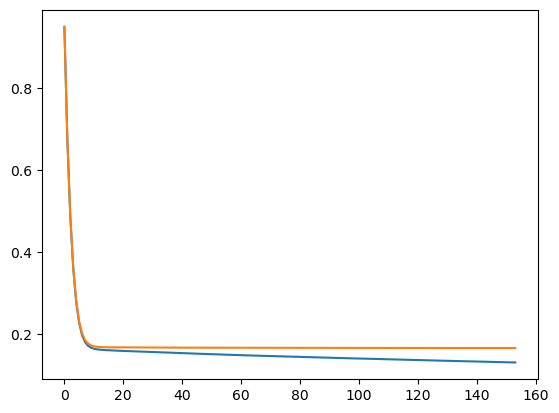

In [31]:
plt.plot(output['history']['train']['rmse']);
plt.plot(output['history']['val']['rmse']);

In [62]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

(10.0, 50.0)

[Text(0, 0, 'Cells_Intensity_MinIntensity_Mito'),
 Text(0, 1, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of20'),
 Text(0, 2, 'Cells_AreaShape_Zernike_7_3'),
 Text(0, 3, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_7of20'),
 Text(0, 4, 'Cytoplasm_Granularity_13_DNA'),
 Text(0, 5, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_7of16'),
 Text(0, 6, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_1of20'),
 Text(0, 7, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20'),
 Text(0, 8, 'Nuclei_Children_Cytoplasm_Count'),
 Text(0, 9, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of16'),
 Text(0, 10, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of16'),
 Text(0, 11, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of20'),
 Text(0, 12, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_6of16'),
 Text(0, 13, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_5of20'),
 Text(0, 14, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_8of20'),

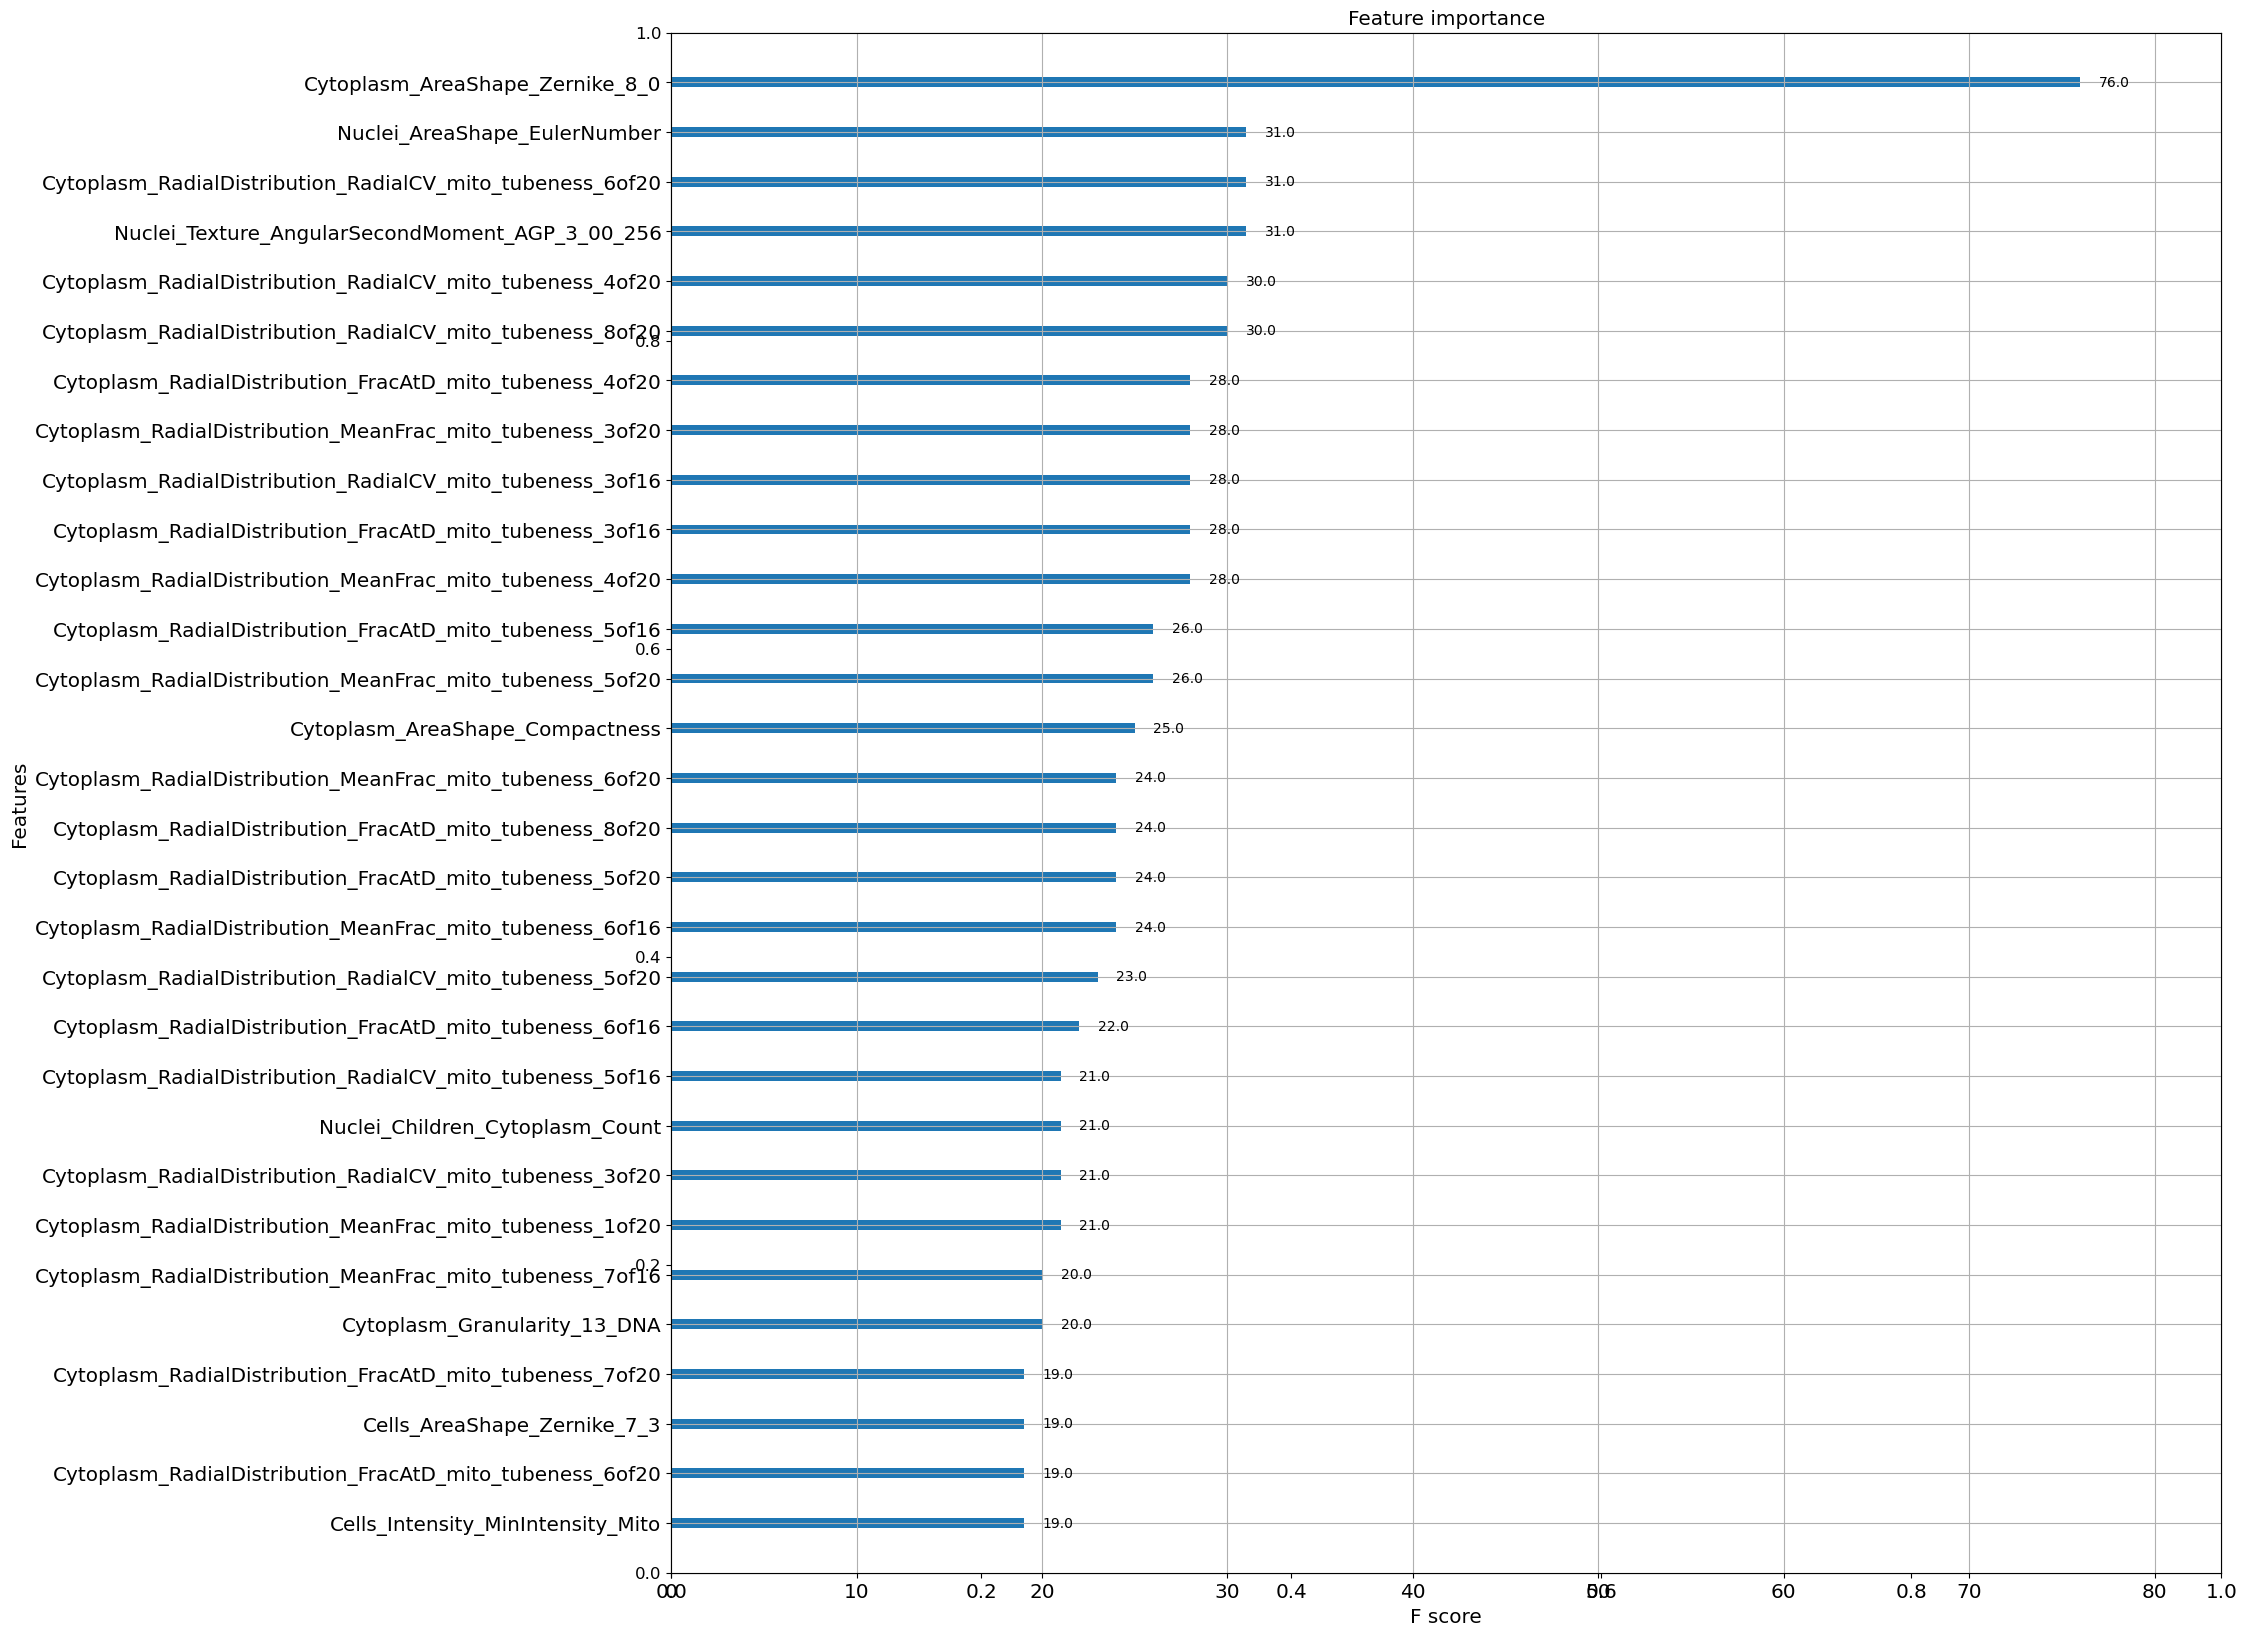

In [99]:
fig = plt.figure(figsize=(20, 20))
plt.yticks(fontsize = 12)
ax = fig.add_subplot()
ax.set_xlim(10,50)
ax = xgb.plot_importance(output['booster'], max_num_features= 30, ax = ax)
# for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(22)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)


In [101]:
output['booster'][133].save_model('./save_20231218_233500_model.json')

In [104]:
config = output['booster'][133].save_config()
type(config)
print(config)

str

{"learner":{"generic_param":{"fail_on_invalid_gpu_id":"0","gpu_id":"-1","n_jobs":"2","nthread":"2","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"1","size_leaf_vector":"0"},"gbtree_train_param":{"predictor":"auto","process_type":"default","tree_method":"hist","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"updater":{"grow_quantile_histmaker":{"train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0",

In [101]:
output['booster'][133].save_model('./save_20231218_233500_model.json')

## Training using XGBoost Scikit-Learn Interface

**XGBRegressor**

Implementation of the scikit-learn API for XGBoost regression. See Using the Scikit-Learn Estimator Interface for more information.

- **Gamma:** Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

- **max_depth:** Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. \
  Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.

- **min_child_weight:** Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of \
  instance weight less than min_child_weight, then the building process will give up further partitioning.

- **subsample:** Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.\
   Subsampling will occur once in every boosting iteration.
  

- **colsample_bytree:** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.


- **lambda:** L2 regularization term on weights. Increasing this value will make model more conservative.

In [ ]:
from sklearn.metrics import get_scorer_names
pp.pprint(get_scorer_names())
# for i in get_scorer_names() :
#     if "error" in i:
#         print(i)

In [25]:
early_stop = xgb.callback.EarlyStopping(rounds=10, 
                                        metric_name='rmse', 
                                        # data_name='Validation_0', 
                                        save_best=True, 
                                        maximize = False,
)

In [26]:
early_stop.best_scores
early_stop.metric_name
early_stop.current_rounds
# early_stop.stopping_history
# len(early_stop.best_scores['validation_']['rmse'])

{}

'rmse'

0

In [20]:
xgb_reg = xgb.XGBRegressor(random_state =123, 
                           n_jobs=-1 ,
                           objective ='reg:squarederror', 
                           eval_metric = "rmse",
                           tree_method='hist', 
                           early_stopping_rounds= 4,
                           # booster = 'gbtree', 
                           device = "cuda",
                           gpu_id = 0,
                           # client = client, 
                           verbosity=2,
                           subsample = 1,
                           sampling_method="uniform",
                           # callbacks = [early_stop],
                          )
# xgb.XGBRFRegressor 
# xgb.XGBModel

In [28]:
# xgb_reg.set_params(tree_method="hist", device = "cuda")
# xgb_reg.set_params(early_stopping_rounds= 3)
# xgb_reg.set_params(gpu_id = 0)
# xgb.client = client

In [29]:
print('Default Parameters :\n')
pp.pprint(xgb_reg.get_params())

Default Parameters :

{   'base_score': None,
    'booster': None,
    'callbacks': [<xgboost.callback.EarlyStopping object at 0x7f76d26698d0>],
    'client': <Client: 'tcp://127.0.0.1:45525' processes=2 threads=4, memory=11.69 GiB>,
    'colsample_bylevel': None,
    'colsample_bynode': None,
    'colsample_bytree': None,
    'device': 'cuda',
    'early_stopping_rounds': 4,
    'enable_categorical': False,
    'eval_metric': 'rmse',
    'feature_types': None,
    'gamma': None,
    'gpu_id': 0,
    'grow_policy': None,
    'importance_type': None,
    'interaction_constraints': None,
    'learning_rate': None,
    'max_bin': None,
    'max_cat_threshold': None,
    'max_cat_to_onehot': None,
    'max_delta_step': None,
    'max_depth': None,
    'max_leaves': None,
    'min_child_weight': None,
    'missing': nan,
    'monotone_constraints': None,
    'n_estimators': 100,
    'n_jobs': 6,
    'num_parallel_tree': None,
    'objective': 'reg:squarederror',
    'predictor': None,
    '

In [21]:
# xgb_grid_parameters = {
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [12, 10 ,8],
#     'max_depth': [15,10,5],
#     'min_child_weight':[5,3,1], 
#     'min_child_weight':[2,3], 
#     'gamma':[1,5, 10],  
#     'gamma':[2.5, 3, 3.5, 4],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'subsample':[0.5],
#     'colsample_bytree':[i/10.0 for i in range(5,11)], 
#     'colsample_bytree':[0.5], 
#     'n_estimators': [1250, 1000, 750, 500]}

xgb_grid_parameters = {
    'learning_rate': [0.1 ],
    'max_depth': [15],
    'min_child_weight':[2], 
    'gamma':[2.5],  
    'subsample':[0.5],
    'colsample_bytree':[0.5], 
    'n_estimators': [100, 200, 300]
    }

# xgb_grid_parameters = {
#     'learning_rate': 0.1,
#     'max_depth': 15,
#     'min_child_weight':2, 
#     'gamma':2.5,  
#     'subsample':0.5,
#     'colsample_bytree':0.5, 
#     'n_estimators': 200
#     }

# xgb_reg.set_params(**xgb_grid_parameters)

In [22]:
# xgb_pcfp = model_selection(xgb_reg, 
                           # xgb_grid_parameters, train_X, train_y, 
                           # scoring =  'neg_mean_squared_error', cv=5, 
                           # GridSearch = True, 
                           # n_iter=30, 
                           # n_jobs=6, 
                           # verbose= 3)

In [ ]:
# xgb_reg.fit(train_X, train_y, verbose = 3, eval_set=[(train_X, train_y), (val_X, val_y)])


In [23]:
import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
import joblib
from dask.distributed import Client
client = Client(processes = False)

In [24]:
model_train = GridSearchCV(xgb_reg, xgb_grid_parameters, 
                               cv=3, 
                               scoring = None,
                               # scheduler=client,
                               refit = True,)
# model_train = GridSearchCV(xgb_reg, xgb_grid_parameters, 
#                                # cv=3, 
#                                n_jobs = 1,
#                                scoring = None,
#                                # refit = True,
#                           )
# model_train = IncrementalSearchCV(xgb_reg, 
#                                   xgb_grid_parameters, 
#                                   n_initial_parameters=1,
#                                   # cv=3, 
#                                   # n_jobs = 1,
#                                     patience = 5,
#                                     random_state = 1234, 
#                                scoring = None,
#                                # refit = True,
#                           )

In [25]:
with joblib.parallel_backend('dask'):
    # model_train.fit(train_X, train_y, eval_set=[(train_X, train_y),(val_X, val_y)],  verbose = 3 )
    model_train.fit(train_X, train_y,   verbose = 3 )

2023-12-20 13:27:13,129 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:16,722 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:18,824 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:19,419 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:19,904 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:25,218 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:25,704 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-20 13:27:26,208 - distributed.utils_perf - WARNING - full garbage collections took

AttributeError: 'DataFrame' object has no attribute 'take'

2023-12-20 14:18:41,629 - distributed.worker - WARNING - Compute Failed
Key:       batch_of__fit_and_score_1_calls-bb48d762a2104268b0760ae044c66ea7
Function:  execute_task
args:      ((<function apply at 0x7f102fab1da0>, batch_of__fit_and_score_1_calls, [], {'tasks': [(<sklearn.utils.parallel._FuncWrapper object at 0x7f0ff50032d0>, [XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device='cuda', early_stopping_rounds=4,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=2.5, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, 

In [146]:
bst = xgb_reg.get_booster()
history = xgb_reg.evals_result()

In [148]:
# history
xgb_reg.best_iteration
xgb_reg.base_score
xgb_reg.best_ntree_limit
# xgb_reg.best_score
xgb_reg.callbacks
xgb_reg.eval_metric
type(bst)

34

35

'rmse'

xgboost.core.Booster

In [163]:
# len(xgb_reg.feature_importances_[xgb_reg.feature_importances_ < 1e-06])
xgb_reg.feature_importances_ 
xgb_reg.feature_names_in_
xgb_reg.n_features_in_
 

array([5.1020330e-04, 2.9500952e-04, 2.7701784e-05, ..., 1.1411206e-03, 0.0000000e+00, 0.0000000e+00], dtype=float32)

AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

In [ ]:
train_score = xgb_reg.score(train_X, train_y)

val_score = xgb_reg.score(val_X, val_y)

test_score = xgb_reg.score(test_X, test_y)

In [160]:
print(f" R2 score - Training   : {train_score:0.4f}")
print(f" R2 score - Validation : {val_score:0.4f}")
print(f" R2 score - Test data  : {test_score:0.4f}")

 R2 score - Training   : 0.1423
 R2 score - Validation : 0.0286
 R2 score - Test data  : 0.0348


In [164]:
 train_X.head()

2023-12-19 20:12:00,484 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-12-19 20:12:00,690 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


,Nuclei_Granularity_6_DNA,Nuclei_AreaShape_Eccentricity,Cytoplasm_Granularity_13_ER,Cytoplasm_Texture_InverseDifferenceMoment_DNA_3_02_256,Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_6of16,Nuclei_Granularity_12_DNA,Cytoplasm_RadialDistribution_RadialCV_RNA_4of4,Cells_AreaShape_Zernike_3_3,Nuclei_Texture_Correlation_AGP_5_01_256,Cytoplasm_Texture_InfoMeas1_ER_10_02_256,...,Cytoplasm_Texture_InfoMeas1_RNA_10_03_256,Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_9of16,Cells_AreaShape_MinorAxisLength,Cells_Correlation_Manders_DNA_ER,Nuclei_Texture_InfoMeas1_AGP_10_03_256,Cells_Texture_InfoMeas2_ER_10_01_256,Nuclei_Intensity_MassDisplacement_Mito,Cells_RadialDistribution_FracAtD_Mito_4of4,Cytoplasm_Intensity_MassDisplacement_AGP,Nuclei_Texture_Entropy_Mito_10_03_256
26,1.196334,-0.397481,0.724691,1.004189,-0.105704,-1.278666,0.767760,-0.424706,-0.593053,0.243792,...,1.071926,0.011111,0.100144,0.109165,0.258738,0.443279,-0.449390,-0.664559,0.436509,-1.154236
64,-0.299009,-0.733161,-0.266611,-0.998694,-0.105704,0.920366,-0.245844,1.011970,0.430854,-0.207958,...,-0.452197,-0.085263,-0.097612,0.204523,-0.189747,-0.329345,-0.609374,0.257169,0.023909,-0.202004
290,-0.582248,-0.105823,-0.860492,-0.487063,-0.105704,1.099416,-1.091219,-0.173999,-0.367616,0.522196,...,0.785181,-0.085263,-0.191325,0.172894,0.520141,-0.572552,-0.789225,0.652670,-0.617449,-0.970951
196,-0.314529,-0.625166,-0.002133,0.715410,-0.105704,-0.082638,0.314918,0.967518,-0.293275,-0.897839,...,0.142782,-0.085263,-0.047999,0.122383,0.493659,0.675974,-0.306136,-0.282906,-0.146683,1.031006
43,0.369899,-0.021215,0.167909,0.170351,-0.105704,-0.349906,0.220752,0.298966,-0.384092,-0.054748,...,-0.157301,-0.050302,-0.113507,0.184696,0.122591,0.126011,0.013832,-0.241362,-0.260922,-0.057361


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

(10.0, 50.0)

[Text(0, 0, 'f1356'),
 Text(0, 1, 'f1424'),
 Text(0, 2, 'f8'),
 Text(0, 3, 'f489'),
 Text(0, 4, 'f1247'),
 Text(0, 5, 'f3'),
 Text(0, 6, 'f195'),
 Text(0, 7, 'f198'),
 Text(0, 8, 'f595'),
 Text(0, 9, 'f797'),
 Text(0, 10, 'f354'),
 Text(0, 11, 'f681'),
 Text(0, 12, 'f776'),
 Text(0, 13, 'f973'),
 Text(0, 14, 'f59'),
 Text(0, 15, 'f320'),
 Text(0, 16, 'f403'),
 Text(0, 17, 'f439'),
 Text(0, 18, 'f455'),
 Text(0, 19, 'f890'),
 Text(0, 20, 'f1139'),
 Text(0, 21, 'f1208'),
 Text(0, 22, 'f4'),
 Text(0, 23, 'f269'),
 Text(0, 24, 'f1235'),
 Text(0, 25, 'f1'),
 Text(0, 26, 'f197'),
 Text(0, 27, 'f260'),
 Text(0, 28, 'f1455'),
 Text(0, 29, 'f0')]

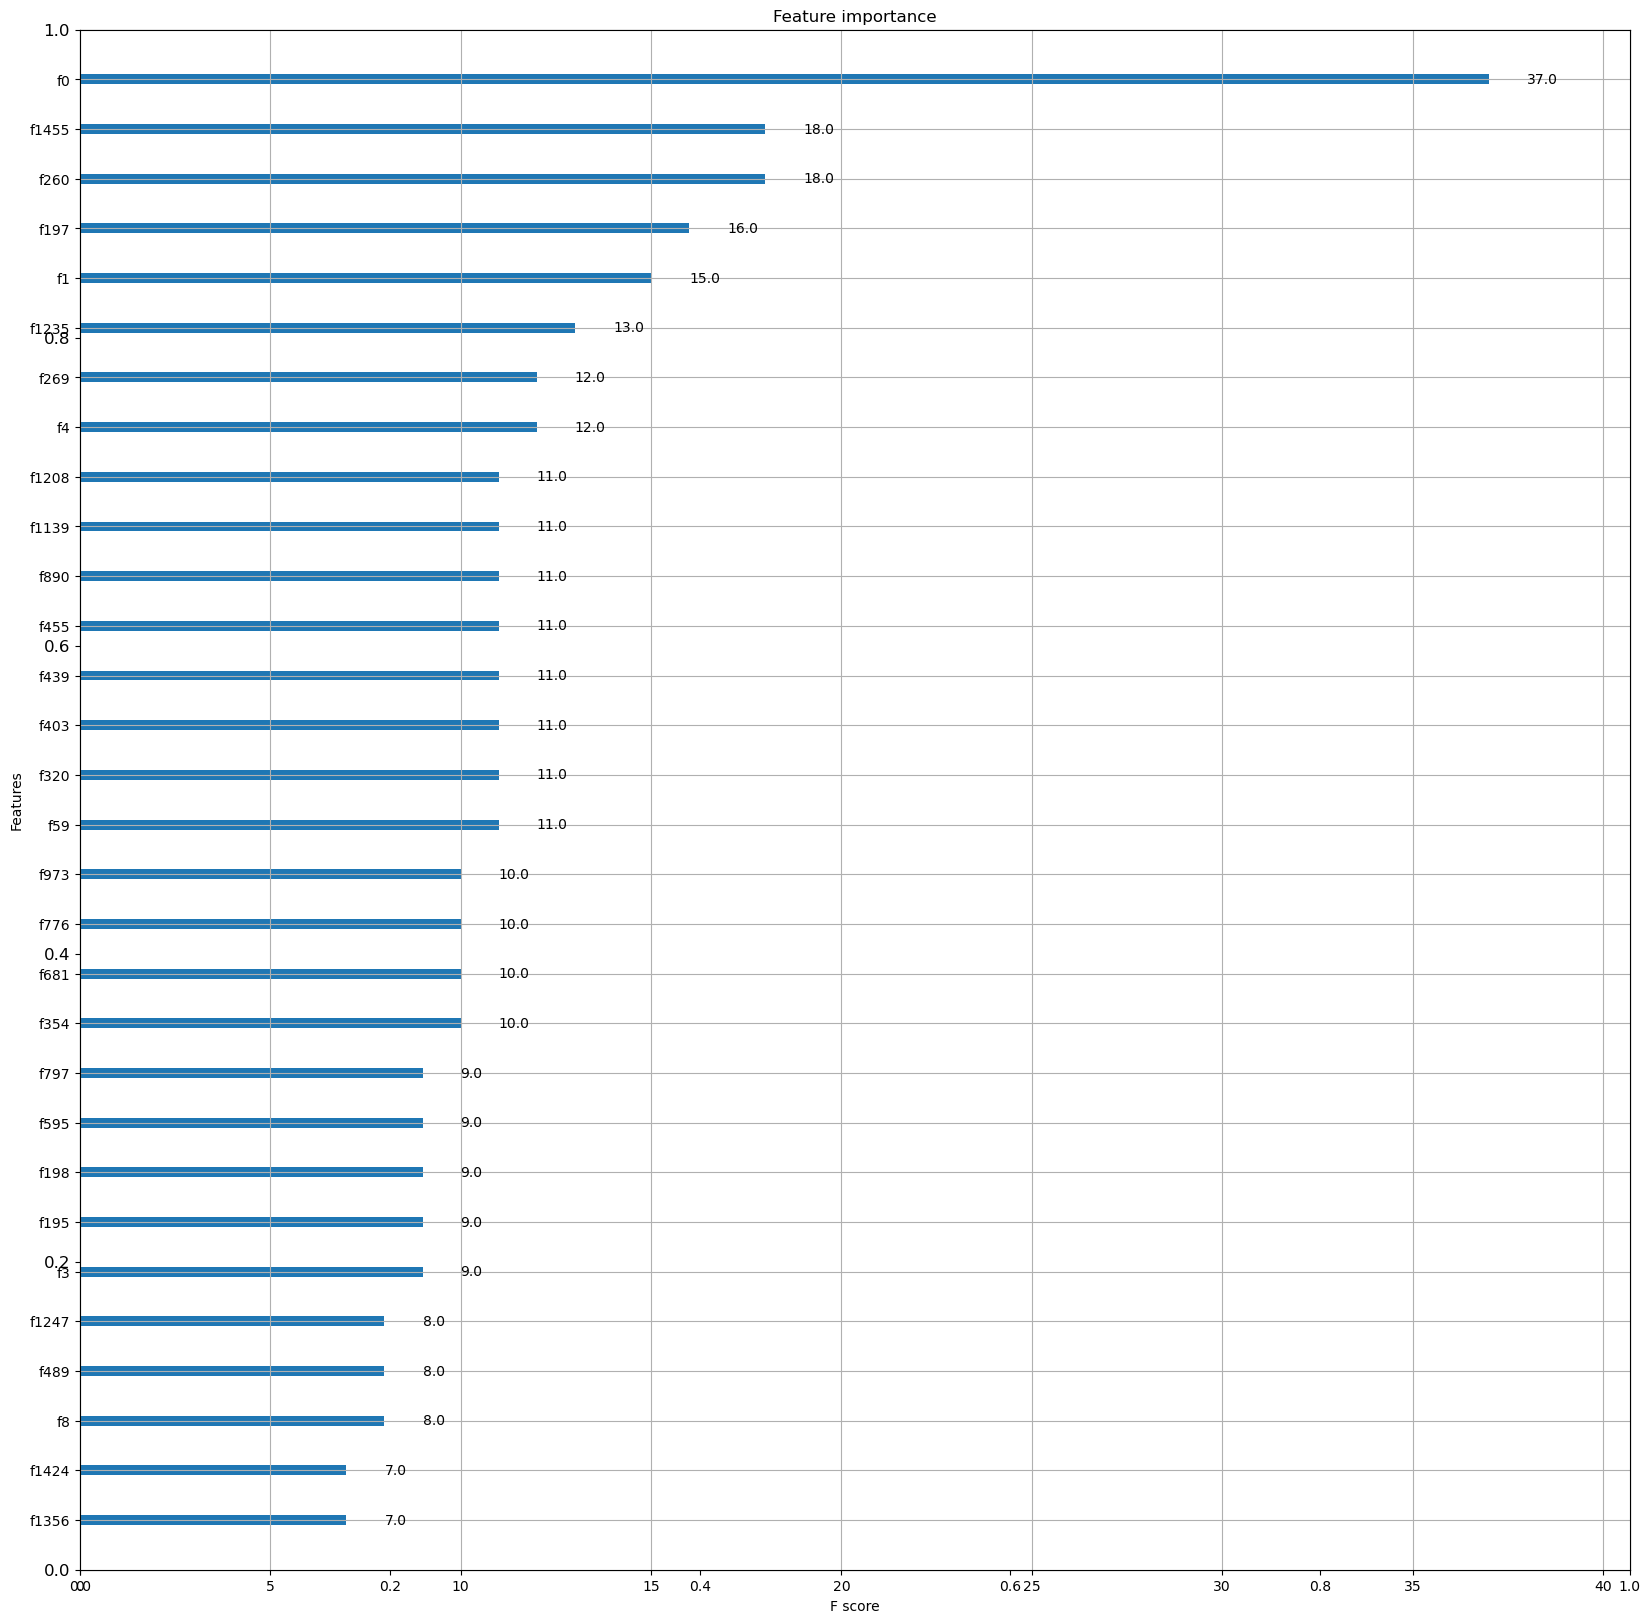

In [161]:
fig = plt.figure(figsize=(20, 20))
plt.yticks(fontsize = 12)
ax = fig.add_subplot()
ax.set_xlim(10,50)
ax = xgb.plot_importance(xgb_reg, max_num_features= 30, ax = ax)
# for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(22)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

### Comments

In [ ]:
# idx = my_enumerator()
# fn = model_selectiona
# args = (1,xgb_reg, xgb_grid_parameters, train_X, train_y)

# kwargs = dict({'scoring':'neg_mean_squared_error', 'cv':5, 'GridSearch':True, 'n_iter':30, 'n_jobs':6, 'verbose': 4}) 
 
# start_time = time.perf_counter()
# print(f" {datetime.now().strftime('%X.%f')} | Started ")   
# pool = Pool(processes=2)

# # result = pool.starmap_async(get_pharmacophores, enumerate(df_iterator)) 
# # results = starmap_with_kwargs_async(pool, fn, args, kwargs, processes = 1)
# results = pool.apply_async(fn,args, kwargs)

# print(f" {datetime.now().strftime('%X.%f')} | starmap_with_kwargs_async() | close pool. . .  ") 
# pool.close()

# print(f" {datetime.now().strftime('%X.%f')} | starmap_with_kwargs_async() | Waiting for results. . .  ")    

In [28]:
# %%time

## returns: a: labeled_feature, b: unlabeled_feature, c: labeled_Y, d: df_labeled.index, e: df_unlabled.index
# a,b,c,d,e = prepare_input(train_labels, train_ecfp6_bits, target = 'logLD50_mmolkg', encoder = None)

## Calls 
# xgb_pcfp = model_selection(xgb_reg, 
                           # xgb_grid_parameters, train_X, train_y, 
                           # scoring =  'neg_mean_squared_error', cv=5, 
                           # GridSearch = True, 
                           # n_iter=30, 
                           # n_jobs=6, 
                           # verbose= 3)

In [ ]:
#  verbose is 3
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Best parameters set found on development set: {'colsample_bytree': 0.5, 'gamma': 2.5, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
# Best score: -0.06345690434364994
# Grid scores on development set:

# -0.06349 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 2.5, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06346 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 2.5, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06505 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06508 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06638 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 3.5, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06638 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 3.5, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06788 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 1500, 'subsample': 0.5}
# -0.06788 (+/-0.002) for {'colsample_bytree': 0.5, 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
# CPU times: user 6.46 s, sys: 286 ms, total: 6.74 s
# Wall time: 3min 7s
    
#     	model	params	mean score	std score	rank
# 0	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 2.5, 'learn...	-0.063492	0.001178	2
# 1	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 2.5, 'learn...	-0.063457	0.001010	1
# 2	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 3, 'learnin...	-0.065046	0.000987	3
# 3	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 3, 'learnin...	-0.065080	0.000957	4
# 4	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 3.5, 'learn...	-0.066377	0.001204	5
# 5	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 3.5, 'learn...	-0.066377	0.001204	5
# 6	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 4, 'learnin...	-0.067878	0.001242	7
# 7	xgb_pcfp	{'colsample_bytree': 0.5, 'gamma': 4, 'learnin...	-0.067878	0.001242	7

In [ ]:
# df_results = result_model_selection(results = xgb_pcfp, name='xgb_pcfp');
# df_results

In [ ]:
# df_results.sort_values('rank')

In [ ]:
# df_results.loc[1].params - 
# {'colsample_bytree': 0.5,
#  'gamma': 2.5,
#  'learning_rate': 0.1,
#  'max_depth': 15,
#  'min_child_weight': 3,
#  'n_estimators': 1500,
#  'subsample': 0.5} 


# df_results.loc[2].params = 
# {'colsample_bytree': 0.5,
#  'gamma': 2.5,
#  'learning_rate': 0.1,
#  'max_depth': 15,
#  'min_child_weight': 3,
#  'n_estimators': 1500,
#  'subsample': 0.5}

# df_results.loc[12].params

In [ ]:
ALL_RESULTS = []
ALL_RESULTS.append(df_results)

# Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torchinfo import summary
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=180, profile=None, sci_mode=None)
## Set visible GPU device 
##----------------------------------------------
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

In [ ]:
@torch.no_grad()
def validation(val_steps=50):
    loss = 0
    for i in range(val_steps):
        ix = torch.randint(0, val_X.shape[0], (batch_size,))
        Xv, Yv = torch.Tensor(val_X[ix]).to(device), torch.Tensor(val_y[ix]).to(device) # batch X,Y
        logits = model(Xv)
        loss += F.mse_loss(logits, Yv)
    loss /= val_steps
    return loss 

# import torchmetrics 
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    """
    compute loss for data split passed (training, validation, or test data)
    """
#     from torch.torcheval.metrics import R2Score    
    from torchmetrics.regression import R2Score, PearsonCorrCoef
    x_numpy,y_numpy = {
    'train': (train_X, train_y),
    'val'  : (val_X  , val_y),
    'test' : (test_X , test_y),
    }[split]
    x = torch.Tensor(x_numpy).to(device)
    y = torch.Tensor(y_numpy).to(device) 
    logits = model(x)
#     print(f" size of logits: {logits.shape}   size of y: {y.shape}")
    mse_loss = F.mse_loss(logits, y)
    r2score = R2Score().to(device)
    pearson = PearsonCorrCoef(num_outputs=1).to(device)
    r2_loss = r2score(logits, y) 
    pearson_loss= pearson(logits.view(-1), y.view(-1))
    print(f"\n {split:5s} data:   MSE loss: {mse_loss.item():10.4f}    R2 Score: {r2_loss.item():.5f}     Pearson Coeff. {pearson_loss:.4f}")
    
@torch.no_grad()
def calc_loss(x,y):
    logits = model(x)
    loss = F.mse_loss(logits, y)
    print(y[:20].T)
    print(logits[:20].T)
    print(f"Calculated loss:  {loss.item():5e}")
    

In [ ]:
del model

In [ ]:
# hierarchical network
#  nn.Linear(n_hidden_2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
# del model

n_input = 1032 # the dimensionality of the character embedding vectors
n_hidden_1 = 128 # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 64 # the number of neurons in the hidden layer of the MLP
model = nn.Sequential(
    nn.Linear(n_input , n_hidden_1, bias=False), 
    nn.BatchNorm1d(n_hidden_1), 
    nn.Tanh(),
    nn.Linear(n_hidden_1, n_hidden_2, bias=False), 
    nn.BatchNorm1d(n_hidden_2), 
    nn.Tanh(),
    nn.Linear(n_hidden_2, 1),
)
model.to(device)

In [ ]:
# print(type(model))
# print(type(model[-1]))
model[-1].__dict__
model[-1].weight.shape
model[-1].bias.shape
model[-1].weight
# parameter init
with torch.no_grad():
    model[-1].weight *= 0.1 # last layer make less confident
model[-1].weight

In [ ]:
parameters = model.parameters()
ttl_nelements = 0
for p in parameters:
    print(f"Parm shape: {str(p.shape):35s}    # elements: {p.nelement():8d}    Required gradient calc: {p.requires_grad}")
    ttl_nelements += p.nelement()
print(ttl_nelements)

print(f"Total num of parameters: {sum(p.nelement() for p in model.parameters())}") # number of parameters in total
for p in parameters:
    p.requires_grad = True

summary(model, 
        input_size = (1,1032),
        verbose =2, 
        col_names = ["input_size", "output_size", "num_params", "params_percent",  "mult_adds","trainable"],
        col_width=16,
        row_settings=["var_names"],);

In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
start_step = 0
end_step = 200000


In [ ]:
# create a PyTorch optimizer
init_LR = 1e-3
curr_LR = init_LR
step_size = 100000
start_step = 0
end_step  = 200000
batch_size = 64
lossi = []
lossv = []

optimizer = torch.optim.AdamW(model.parameters(), lr=init_LR)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.1, last_epoch= -1 , verbose=False)

In [ ]:
model.train();
for i in range(start_step, end_step):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = torch.Tensor(train_X[ix]).to(device), torch.Tensor(train_y[ix]).to(device) # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss_mse = F.mse_loss(logits, Yb)

    optimizer.zero_grad(set_to_none=True)
    loss_mse.backward()

    optimizer.step()

    lossi.append(loss_mse.log10().item())
    
    scheduler.step()

    # track stats
    if i % 1000 == 0:
        val_loss_mse = validation()
        lossv.append(val_loss_mse.log10().item())
        print(f" {datetime.now().strftime('%X.%f')} | batch: {i:7d}/{end_step:7d} | training loss: {loss_mse.item():11.6f} | validation loss: {val_loss_mse.item():11.6f}") 
    
        if i % 50000 == 0:
            if curr_LR != optimizer.param_groups[0]['lr']:
                curr_LR = optimizer.param_groups[0]['lr']
                print(f" ===> learning rate adjusted to {curr_LR}")        
            model.eval();
            print(f"**{i//50000} iterations**")
            split_loss('train')
            split_loss('val')
            split_loss('test')
            print()
            model.train();

## End of training loop
        
print(f" start_step : {start_step}     end_step: {end_step}    i: {i}")    

model.eval();
split_loss('train')
split_loss('val')
split_loss('test')
model.train();



In [ ]:
# start_step = end_step
# end_step += 50000

In [ ]:
print(f" start_step : {start_step}     end_step: {end_step}     end_step: {end_step - start_step}   i: {i}      learning rate: {optimizer.param_groups[0]['lr']}")    

In [ ]:
# for g in optimizer.param_groups:
#     g['lr']=1e-4
#     print(g)

In [ ]:
print(len(lossi), len(lossv));
# print(lossi[0], lossi[-1])
# lossi.pop()
# print(len(lossi), len(lossv));
# print(lossi[0], lossi[-1])
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));
plt.plot(torch.tensor(lossv).view(-1));


In [ ]:
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:~:text=The%20r2_score%20function%20computes,score%20of%200.0.

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
model.eval();
split_loss('train')
split_loss('val')
split_loss('test')
model.train();

**training using TPSA**

     train data:        MSE loss:   125.6541    R2 Score: 0.88529     Pearson Coeff. 0.9419

     val   data:        MSE loss:   290.9020    R2 Score: 0.67287     Pearson Coeff. 0.8236

     test  data:        MSE loss:   384.7767    R2 Score: 0.67663     Pearson Coeff. 0.8230
      
      

### MinMax TPSA 128 x 64 , no BatchNorm 

**MinMax TPSA 128 x 64 , no BatchNorm**

**50k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.79670     Pearson Coeff. 0.8926

     val   data:        MSE loss:     0.0001    R2 Score: 0.68855     Pearson Coeff. 0.8333

     test  data:        MSE loss:     0.0002    R2 Score: 0.66196     Pearson Coeff. 0.8145


**100k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.88567     Pearson Coeff. 0.9418

     val   data:        MSE loss:     0.0001    R2 Score: 0.70376     Pearson Coeff. 0.8402

     test  data:        MSE loss:     0.0002    R2 Score: 0.70878     Pearson Coeff. 0.8433
      
      
**150k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.88960     Pearson Coeff. 0.9438

     val   data:        MSE loss:     0.0001    R2 Score: 0.70221     Pearson Coeff. 0.8394

     test  data:        MSE loss:     0.0002    R2 Score: 0.70636     Pearson Coeff. 0.8420
      
      
**200k iterations**

    train data:        MSE loss:     0.0001    R2 Score: 0.89114     Pearson Coeff. 0.9441

     val   data:       MSE loss:     0.0001    R2 Score: 0.70325     Pearson Coeff. 0.8394

     test  data:       MSE loss:     0.0002    R2 Score: 0.70603     Pearson Coeff. 0.8416
      

**250k iterations**      
      
     train data:        MSE loss:     0.0001    R2 Score: 0.89125     Pearson Coeff. 0.9440

     val   data:        MSE loss:     0.0001    R2 Score: 0.70360     Pearson Coeff. 0.8398

     test  data:        MSE loss:     0.0002    R2 Score: 0.70624     Pearson Coeff. 0.8417  
      

### MinMax TPSA 128 x 64 , With BatchNorm 

**MinMax TPSA 128 x 64 , with BatchNorm**

**50k iterations**

     train data:    MSE loss:     0.0001    R2 Score: 0.80766     Pearson Coeff. 0.8994

     val   data:    MSE loss:     0.0001    R2 Score: 0.66401     Pearson Coeff. 0.8181

     test  data:    MSE loss:     0.0002    R2 Score: 0.68471     Pearson Coeff. 0.8312


**100k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.85963     Pearson Coeff. 0.9295

     val   data:    MSE loss:     0.0001    R2 Score: 0.68456     Pearson Coeff. 0.8308

     test  data:    MSE loss:     0.0002    R2 Score: 0.69034     Pearson Coeff. 0.8358      
      
      
**150k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.87261     Pearson Coeff. 0.9345

     val   data:    MSE loss:     0.0001    R2 Score: 0.69643     Pearson Coeff. 0.8354

     test  data:    MSE loss:     0.0002    R2 Score: 0.69435     Pearson Coeff. 0.8362

      
**200k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.87318     Pearson Coeff. 0.9345

     val   data:    MSE loss:     0.0001    R2 Score: 0.69366     Pearson Coeff. 0.8337

     test  data:    MSE loss:     0.0002    R2 Score: 0.69301     Pearson Coeff. 0.8363      
     

**250k iterations**      
      
     train data:    MSE loss:     0.0001    R2 Score: 0.87323     Pearson Coeff. 0.9346

     val   data:    MSE loss:     0.0001    R2 Score: 0.69520     Pearson Coeff. 0.8343

     test  data:    MSE loss:     0.0002    R2 Score: 0.69483     Pearson Coeff. 0.8368
      

In [ ]:
from sklearn.metrics import get_scorer_names
for i in get_scorer_names() :
    if "error" in i:
        print(i)

## Evaluation on Test dataset

In [ ]:
model.eval()
# minibatch construct
ix = torch.randint(0, train_X.shape[0], (batch_size,))
Xb, Yb = torch.Tensor(train_X[ix]).to(device), torch.Tensor(train_y[ix]).to(device) # batch X,Y

print(ix)
logits = model(Xb)
with torch.no_grad():
    a,b = logits.cpu().numpy().squeeze(), Yb.cpu().numpy().squeeze()
    print(a.shape, b.shape)
    for i, j in zip(logits.cpu().numpy(), Yb.cpu().numpy()):
        print(f" {i[0]:.5f}     {j[0]:.5f}")

# EDA - Generate Data Profile

In [ ]:
# profile = ProfileReport(df_labels, title="Profiling Report")
# profile_report = df_labels.profile(html={"style": {"full_width": True}})
# profile.to_file("./output/example.html")

### profile widgets

In [ ]:
# profile.to_widgets()

### profile notebook iframe

In [ ]:
# profile.to_notebook_iframe()

## Create label file `all_y1` from `df_tpsa[TPSA]`

In [ ]:
# del tpsa_norm, tpsa_numpy,tpsa_numpy_1, normalizer

###  Normalize data 

In [ ]:
# tpsa_numpy =df_labels['log10TPSA'].to_numpy().reshape(-1,1)
tpsa_numpy =df_labels['TPSA'].to_numpy().reshape(-1,1)


print(f" {tpsa_numpy.shape}  min:  {tpsa_numpy.min()},   max: {tpsa_numpy.max()},  mean: {tpsa_numpy.mean():.4f}, std dev: {tpsa_numpy.std():.4f}")
print("           ",tpsa_numpy[:10].T)

# normalize function 
print(f"\n Using normalize function")
print(f" --------------------------")
normalizer = Normalizer()
tpsa_norm  = normalizer.fit_transform(tpsa_numpy)
print(f" Parameters: {normalizer.get_params(deep=True)}")
# # all_y = normalizer.transform(tpsa_numpy)
print(f" {tpsa_norm.shape}  min:  {tpsa_norm.min()},   max: {tpsa_norm.max():.4f},  mean: {tpsa_norm.mean():.4f}, std dev: {tpsa_norm.std():.4f}")
print(f" First 10 elements : {tpsa_norm[:10].T}")      

print(f"\n Using MaxAbsScaler ")
print(f" --------------------------")
scaler  = MaxAbsScaler()
print(f" type of scaler: {type(scaler)}  ")
tpsa_maxabs  = scaler.fit_transform(tpsa_numpy)
print(f" Parameters: {scaler.get_params(deep=True)}")
# # all_y = normalizer.transform(tpsa_numpy)
print(f" {tpsa_maxabs.shape}  min:  {tpsa_maxabs.min()},   max: {tpsa_maxabs.max():.4f},  mean: {tpsa_maxabs.mean():.4f}, std dev: {tpsa_maxabs.std():.4f}")
print(f"  First 10 elements : {tpsa_maxabs[:10].T}")      

print(f"\n Using MinMaxScaler ")
print(f" --------------------------")
scaler  = MinMaxScaler(feature_range=(-1,1))
print(f" type of scaler: {type(scaler)}")
print(f" Parameters: {scaler.get_params(deep=True)}")
tpsa_minmax  = scaler.fit_transform(tpsa_numpy)
print(f" {tpsa_minmax.shape}  min:  {tpsa_minmax.min()},   max: {tpsa_minmax.max():.4f},  mean: {tpsa_minmax.mean():.4f}, std dev: {tpsa_minmax.std():.4f}")
print(f" First 10 elements : {tpsa_minmax[:10].T}")      
      

In [ ]:
# all_y = tpsa_numpy.copy()
all_y = tpsa_minmax.copy()

In [ ]:
print(f" {all_y.shape} -   min:  {all_y.min()}       max: {all_y.max():.4f}      mean: {all_y.mean():.4f}      std dev: {all_y.std():.4f}")
print(f" First 10 elements : {all_y[:10].T}")


## Read fingerprint features file `all_X`

In [ ]:
print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

In [ ]:
all_X = np.load(compoundPharmacophoreDenseZipFile)['dense_mat']
print(type(all_X), all_X.shape, all_X.dtype)
print(all_X[:5, :25])